In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt

pdbbind = pd.read_csv('./data/pdbbind_binding_affinity.csv')
dude = pd.read_csv('./data/dude_info.csv')

In [2]:
ic50 = pdbbind[pdbbind['binding_type'] == 'ic50']
ic50.nsmallest(100, 'binding_affinity')

,Unnamed: 0,id,resolution,release_year,interaction_type,-log(kd/ki),binding_type,binding_affinity
5265,5265,3gww,2.46,2009,protein-ligand,NaN,ic50,1.035637
5260,5260,3fqa,2.35,2009,protein-ligand,NaN,ic50,1.139434
5362,5362,3fl9,2.40,2009,protein-ligand,NaN,ic50,2.561356
11120,11120,4to8,2.10,2014,protein-ligand,NaN,ic50,2.866460
1379,1379,1hty,1.40,2002,protein-ligand,NaN,ic50,3.218876
...,...,...,...,...,...,...,...,...
5241,5241,3hvg,2.26,2009,protein-ligand,NaN,ic50,6.214608
6327,6327,3ftz,2.00,2010,protein-ligand,NaN,ic50,6.214608
12624,12624,4ypf,2.20,2015,protein-ligand,NaN,ic50,6.214608
12625,12625,4yrc,2.10,2015,protein-ligand,NaN,ic50,6.214608


(array([   8.,   76.,  296.,  604.,  986., 1435., 1615.,  846.,  143.,
          11.]),
 array([ 1.03563749,  3.58531462,  6.13499176,  8.68466889, 11.23434602,
        13.78402316, 16.33370029, 18.88337743, 21.43305456, 23.98273169,
        26.53240883]),
 <a list of 10 Patch objects>)

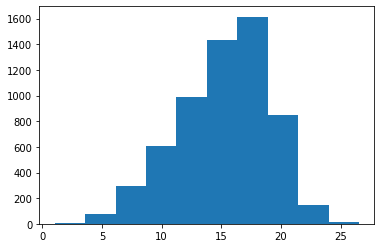

In [3]:
plt.hist(pdbbind[pdbbind['binding_type'] == 'ic50']['binding_affinity'].tolist())

In [4]:
dude = dude.rename(columns={'Target Name': 'dude_id', 'PDB': 'id'})

In [5]:
joined = pd.merge(pdbbind, dude[['dude_id', 'id']], on='id')
joined[joined['binding_type'] == 'ic50'].describe()

,Unnamed: 0,resolution,release_year,-log(kd/ki),binding_affinity
count,38.000000,38.000000,38.000000,0.0,38.000000
mean,4077.657895,2.030000,2007.105263,NaN,16.302776
std,1597.885719,0.341238,3.073773,NaN,3.963944
min,374.000000,1.450000,1997.000000,NaN,7.986565
25%,3529.250000,1.800000,2007.000000,NaN,13.841851
50%,4229.500000,2.000000,2008.000000,NaN,17.035638
75%,5146.750000,2.100000,2009.000000,NaN,19.137093
max,7222.000000,3.300000,2011.000000,NaN,24.229824


In [6]:
dude2pdb_df = pd.read_csv('./data/dude2pdb.csv')
dude2pdb = {row['dude_id']: row['id'] for _, row in dude2pdb_df.iterrows()}

## Visualize Protein 

If nothing shows after running the blocks, run the commands below in your environment.

```
jupyter-nbextension enable --py --sys-prefix widgetsnbextension
jupyter-nbextension enable nglview --py --sys-prefix
```

### 3D Representation of Protein-Ligand Complex

In [ ]:
%load_ext autoreload
%autoreload 2
%pdb off
# set DISPLAY = True when running tutorial
DISPLAY = False
# set PARALLELIZE to true if you want to use ipyparallel
PARALLELIZE = False
import warnings
warnings.filterwarnings('ignore')
import nglview
import tempfile
import os
import mdtraj as md
import numpy as np
#import deepchem.utils.visualization
#from deepchem.utils.visualization import combine_mdtraj, visualize_complex, convert_lines_to_mdtraj

# https://deepchem.io/docs/notebooks/protein_ligand_complex_notebook.html


"""
def convert_lines_to_mdtraj(molecule_lines):
    molecule_lines = molecule_lines.strip('[').strip(']').replace("'","").replace("\\n", "").split(", ")
    tempdir = tempfile.mkdtemp()
    molecule_file = os.path.join(tempdir, "molecule.pdb")
    with open(molecule_file, "w") as f:
        for line in molecule_lines:
            f.write("%s\n" % line)dude_id = 'akt1'
pdbid = dude2pdb.get(dude_id)

sample_protein_pdb = './data/dude/{}/receptor.pdb'.format(dude_id)
sample_pocket_pdb = './data/pdbbind/v2018/{}/{}_pocket.pdb'.format(pdbid, pdbid)

positive_ligand_pdb = './data/dude/{}/actives/actives_1.pdb'.format(dude_id)
negative_ligand_pdb = './data/dude/{}/decoys/decoys_1.pdb'.format(dude_id)
    molecule_mdtraj = md.load(molecule_file)
    return molecule_mdtraj
"""
def visualize_protein(molecule_mdtraj):
    traj = nglview.MDTrajTrajectory(molecule_mdtraj) 
    ngltraj = nglview.NGLWidget( traj )
    
    return ngltraj

def visualize_ligand(ligand_mdtraj):
    traj = nglview.MDTrajTrajectory( ligand_mdtraj ) # load file from RCSB PDB
    ngltraj = nglview.NGLWidget( traj )
    ngltraj.representations = [
        { "type": "ball+stick", "params": {"sele": "all" } } ]
    return ngltraj

def combine_mdtraj(protein, ligand):
    chain = protein.topology.add_chain()
    residue = protein.topology.add_residue("LIG", chain, resSeq=1)
    for atom in ligand.topology.atoms:
        protein.topology.add_atom(atom.name, atom.element, residue)
    protein.xyz = np.hstack([protein.xyz, ligand.xyz])
    protein.topology.create_standard_bonds()

    return protein
    
def visualize_complex(complex_mdtraj):
    ligand_atoms = [a.index for a in complex_mdtraj.topology.atoms if "LIG" in str(a.residue)]
    binding_pocket_atoms = md.compute_neighbors(complex_mdtraj, 0.5, ligand_atoms)[0]
    binding_pocket_residues = list(set([complex_mdtraj.topology.atom(a).residue.resSeq for a in binding_pocket_atoms]))
    binding_pocket_residues = [str(r) for r in binding_pocket_residues]
    binding_pocket_residues = " or ".join(binding_pocket_residues)

    traj = nglview.MDTrajTrajectory( complex_mdtraj ) # load file from RCSB PDB
    ngltraj = nglview.NGLWidget( traj )
    ngltraj.representations = [
    { "type": "cartoon", "params": {
    "sele": "protein", "color": "residueindex"
    } },
    { "type": "licorice", "params": {
    "sele": "(not hydrogen) and (%s)" %  binding_pocket_residues
    } },
    { "type": "ball+stick", "params": {
    "sele": "LIG"
    } }
    ]
    return ngltraj


def visualize_dude_complex(dude_id, type, i, show_pdb=True):
    protein_pdb = './data/dude/{}/receptor.pdb'.format(dude_id)
    
    if dude_id in dude2pdb and show_pdb:
        print('Showing PDBBind ID {}'.format(dude2pdb[dude_id]))
        protein_pdb = './data/pdbbind/v2018/{}/{}_protein.pdb'.format(dude2pdb[dude_id], dude2pdb[dude_id])
    
    ligand_pdb = './data/dude/%s/%s/%s_%d.pdb' % (dude_id, type, type, i)

    return visualize_complex(combine_mdtraj(md.load(protein_pdb), md.load(ligand_pdb)))
    
#first_protein, first_ligand = raw_dataset.iloc[0]["protein_pdb"], raw_dataset.iloc[0]["ligand_pdb"]

#protein_mdtraj = convert_lines_to_mdtraj(first_protein)
#ligand_mdtraj = convert_lines_to_mdtraj(first_ligand)
#complex_mdtraj = combine_mdtraj(protein_mdtraj, ligand_mdtraj)

In [ ]:
dude_id = 'akt1'
pdbid = dude2pdb.get(dude_id)

sample_protein_pdb = './data/pdbbind/v2018/{}/{}_protein.pdb'.format(pdbid, pdbid)
sample_pocket_pdb = './data/pdbbind/v2018/{}/{}_pocket.pdb'.format(pdbid, pdbid)

positive_ligand_pdb = './data/dude/{}/actives/actives_5.pdb'.format(dude_id)
negative_ligand_pdb = './data/dude/{}/decoys/decoys_1.pdb'.format(dude_id)

In [ ]:
protein_traj = md.load(sample_protein_pdb)
pocket_traj = md.load(sample_pocket_pdb)
pos_lig_traj = md.load(positive_ligand_pdb)
neg_lig_traj = md.load(negative_ligand_pdb)

In [ ]:
visualize_protein(md.load(sample_protein_pdb))

In [ ]:
visualize_protein(pocket_traj)

In [ ]:
visualize_ligand(pos_lig_traj)

In [ ]:
visualize_ligand(neg_lig_traj)

In [ ]:
visualize_dude_complex('kif11', 'decoys', 4, show_pdb=False)

In [ ]:
visualize_complex(
    combine_mdtraj(md.load('./data/docking/1l2s/1l2s_pocket.pdb'), 
                   md.load('./data/docking/1l2s/1l2s_docked_actives_1.pdb')))

In [ ]:
visualize_complex(
    combine_mdtraj(md.load('./data/pdbbind/v2018/1l2s/1l2s_protein.pdb'), 
                   md.load('./data/docking/1l2s/1l2s_docked_actives_2.pdb')))

#### As a graph

In [ ]:
%matplotlib inline
from rdkit.Chem.Draw import IPythonConsole
import networkx as nx
from rdkit.Chem.rdmolfiles import MolFromPDBFile
import matplotlib.pyplot as plt

def mol_to_nx(mol):
    
    """
    https://github.com/maxhodak/keras-molecules/pull/32/commits/dbbb790e74e406faa70b13e8be8104d9e938eba2
    """
    G = nx.Graph()

    for atom in mol.GetAtoms():
        G.add_node(atom.GetIdx(),
                   atomic_num=atom.GetAtomicNum(),
                   formal_charge=atom.GetFormalCharge(),
                   chiral_tag=atom.GetChiralTag(),
                   hybridization=atom.GetHybridization(),
                   num_explicit_hs=atom.GetNumExplicitHs(),
                   is_aromatic=atom.GetIsAromatic())
    for bond in mol.GetBonds():
        G.add_edge(bond.GetBeginAtomIdx(),
                   bond.GetEndAtomIdx(),
                   bond_type=bond.GetBondType())
    return G

protein = MolFromPDBFile(sample_protein_pdb)
protein_graph = mol_to_nx(protein)
pos = nx.spring_layout(protein_graph) 
nx.draw(protein_graph, width=1, node_size=2)

### Distance Calculation between protein and ligand

In [ ]:
from Bio.PDB import PDBParser
import numpy as np

def get_centroid(pdbid):
    ligand_pdb = "./data/pdbbind/v2018/{}/{}_ligand.pdb".format(pdbid, pdbid)

    p = PDBParser()
    s = p.get_structure(pdbid, ligand_pdb)                    


    model = [m for m in s][0]
    chain = [c for c in model][0]
    residue = [r for r in chain][0]

    mat = np.array([atom.get_vector().get_array() for atom in residue])
    
    return np.mean(mat, axis=0)


In [ ]:
centroid = get_centroid("1uu3")

In [ ]:
def get_distance_from_ligand_centroid(pdbid):
    pocket_pdb = "./data/pdbbind/v2018/{}/{}_pocket.pdb".format(pdbid, pdbid)

    centroid = get_centroid(pdbid)
    p = PDBParser()
    s = p.get_structure(pdbid.upper(), pocket_pdb)
    
    model = [m for m in s][0]
    chain = [c for c in model][0]
    residue = [r for r in chain][0]
    
    vectors = [atom.get_vector().get_array() for atom in residue]
    
    return [np.linalg.norm(vector - centroid) for vector in vectors]

In [ ]:
pdbid = '2y2i'
get_distance_from_ligand_centroid("2y2i")

In [ ]:
distance_affinity = []
for i in binding_affinity_df[binding_affinity_df["-log(kd/ki)"].notna()].index.tolist():
    pdbid = binding_affinity_df.loc[i, 'id']
    try:
        distance_affinity.append((np.mean(get_distance_from_ligand_centroid(pdbid)), 
                                  binding_affinity_df.loc[i, '-log(kd/ki)']))
    except:
        continue
    

In [ ]:
distance = [da[0] for da in distance_affinity]
affinity = [da[1] for da in distance_affinity]

plt.plot(distance, affinity, 'o')